# NHS A&E Wait Times Prediction: Machine Learning Analysis

**Student ID:** 23068196  
**Course:** Data Mining Final Project  
**Date:** January 06, 2026  
**Dataset:** NHS England A&E Attendances and Emergency Admissions (April 2024 - November 2025)

---

## Research Question

**Can we predict which NHS hospitals will have better or worse A&E performance, and what factors contribute most to longer wait times?**

### Context
The NHS has a target that **95% of A&E patients** should be seen within 4 hours. This analysis examines 20 months of data from 122 Type 1 (Major) A&E departments across England to:
1. Identify patterns in hospital performance
2. Build predictive models for performance levels
3. Determine key factors affecting wait times
4. Provide data-driven policy recommendations

---

## Table of Contents

1. Setup & Data Loading
2. Data Cleaning & Preprocessing
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Model Building & Evaluation
6. Results & Insights
7. Conclusions & Recommendations

<a id='1-setup'></a>
## 1. Setup & Data Loading

Import required libraries and load the dataset.

In [5]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Libraries imported successfully
Analysis Date: 2025-12-28 19:36:02


In [6]:
url = "https://raw.githubusercontent.com/IfeakanduBenedict/nhs_ae_dataset.csv/main/nhs_ae_dataset.csv"

df = pd.read_csv(url)

df['Date'] = pd.to_datetime(df['Date'])

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (2429, 21)


,Date,Hospital_Code,Region,Hospital_Name,Type1_Attendances,Type2_Attendances,Other_Attendances,Type1_Over4hrs,Type2_Over4hrs,Other_Over4hrs,Wait_4to12hrs,Wait_12plus_hrs,Emerg_Admissions,Total_Attendances,Total_Over4hrs,Pct_Within_4hrs,Target_Failed,Year,Month,Quarter,Season
0,2025-11-01,R1F,NHS ENGLAND SOUTH EAST,ISLE OF WIGHT NHS TRUST,4230,253,1528,1539,0,58,231,151,1299,4230,1539,63.62,1,2025,11,4,Autumn
1,2025-11-01,RAX,NHS ENGLAND LONDON,KINGSTON AND RICHMOND NHS FOUNDATION TRUST,7192,0,8197,4095,0,451,340,362,2302,7192,4095,43.06,1,2025,11,4,Autumn
2,2025-11-01,RD1,NHS ENGLAND SOUTH WEST,ROYAL UNITED HOSPITALS BATH NHS FOUNDATION TRUST,8866,0,0,3750,0,0,887,155,2610,8866,3750,57.70,1,2025,11,4,Autumn
3,2025-11-01,RDE,NHS ENGLAND EAST OF ENGLAND,EAST SUFFOLK AND NORTH ESSEX NHS FOUNDATION TRUST,10929,0,13304,5054,0,1413,770,461,4745,10929,5054,53.76,1,2025,11,4,Autumn
4,2025-11-01,RDU,NHS ENGLAND SOUTH EAST,FRIMLEY HEALTH NHS FOUNDATION TRUST,22861,800,11293,9459,0,345,1216,427,6619,22861,9459,58.62,1,2025,11,4,Autumn


<a id='2-cleaning'></a>
## 2. Data Cleaning & Preparation

Verify data quality and prepare for analysis.

In [7]:
# Dataset information
print("DATASET INFORMATION")
df.info()

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2429 non-null   datetime64[ns]
 1   Hospital_Code      2429 non-null   object        
 2   Region             2429 non-null   object        
 3   Hospital_Name      2429 non-null   object        
 4   Type1_Attendances  2429 non-null   int64         
 5   Type2_Attendances  2429 non-null   int64         
 6   Other_Attendances  2429 non-null   int64         
 7   Type1_Over4hrs     2429 non-null   int64         
 8   Type2_Over4hrs     2429 non-null   int64         
 9   Other_Over4hrs     2429 non-null   int64         
 10  Wait_4to12hrs      2429 non-null   int64         
 11  Wait_12plus_hrs    2429 non-null   int64         
 12  Emerg_Admissions   2429 non-null   int64         
 13  Total_Attendances  2429 non-null   int64   

In [8]:
# Check for missing values
print("MISSING VALUES ANALYSIS")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
else:
    print("✓ No missing values found in the dataset!")

MISSING VALUES ANALYSIS
✓ No missing values found in the dataset!


In [9]:
# Basic statistics
print("DESCRIPTIVE STATISTICS")
df.describe()

DESCRIPTIVE STATISTICS


,Date,Type1_Attendances,Type2_Attendances,Other_Attendances,Type1_Over4hrs,Type2_Over4hrs,Other_Over4hrs,Wait_4to12hrs,Wait_12plus_hrs,Emerg_Admissions,Total_Attendances,Total_Over4hrs,Pct_Within_4hrs,Target_Failed,Year,Month,Quarter
count,2429,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000
mean,2025-01-14 17:31:05.953067264,11364.300535,346.296418,4849.348291,4574.355702,14.660766,160.253602,734.419514,362.196789,3289.267600,11364.300535,4574.355702,59.571186,0.998353,2024.547962,6.904076,2.651297
min,2024-04-01 00:00:00,3471.000000,0.000000,0.000000,148.000000,0.000000,0.000000,0.000000,0.000000,498.000000,3471.000000,148.000000,31.400000,0.000000,2024.000000,1.000000,1.000000
25%,2024-08-01 00:00:00,7844.000000,0.000000,1551.000000,2993.000000,0.000000,0.000000,378.000000,41.000000,2074.000000,7844.000000,2993.000000,52.420000,1.000000,2024.000000,5.000000,2.000000
50%,2025-01-01 00:00:00,10179.000000,0.000000,4077.000000,4079.000000,0.000000,57.000000,602.000000,253.000000,2876.000000,10179.000000,4079.000000,59.160000,1.000000,2025.000000,7.000000,3.000000
75%,2025-06-01 00:00:00,13286.000000,300.000000,7490.000000,5590.000000,0.000000,213.000000,936.000000,585.000000,4052.000000,13286.000000,5590.000000,65.780000,1.000000,2025.000000,10.000000,4.000000
max,2025-11-01 00:00:00,36434.000000,4302.000000,19100.000000,15632.000000,719.000000,2835.000000,4456.000000,2232.000000,11732.000000,36434.000000,15632.000000,96.030000,1.000000,2025.000000,12.000000,4.000000
std,NaN,5418.075310,717.635075,4077.898526,2355.957562,49.285440,267.725007,578.793267,379.860380,1763.589104,5418.075310,2355.957562,10.088072,0.040555,0.497797,3.080245,1.013429


In [10]:
# Check for duplicates
duplicates = df.duplicated(subset=['Hospital_Code', 'Date']).sum()
print(f"\nDuplicate hospital-month combinations: {duplicates}")

# Dataset coverage
print("DATASET COVERAGE")
print(f"Total records: {len(df):,}")
print(f"Unique hospitals: {df['Hospital_Code'].nunique()}")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Months covered: {df['Date'].nunique()}")
print(f"Average months per hospital: {len(df)/df['Hospital_Code'].nunique():.1f}")


Duplicate hospital-month combinations: 0
DATASET COVERAGE
Total records: 2,429
Unique hospitals: 122
Date range: 2024-04-01 to 2025-11-01
Months covered: 20
Average months per hospital: 19.9


<a id='3-eda'></a>
## 3. Exploratory Data Analysis (EDA)

Comprehensive analysis of patterns, distributions, and relationships in the data.

### 3.1 Target Variable Analysis

ORIGINAL TARGET VARIABLE (Failed 95% Target)
Target_Failed
1    2425
0       4
Name: count, dtype: int64

Failure rate: 99.84%
Success rate: 0.16%


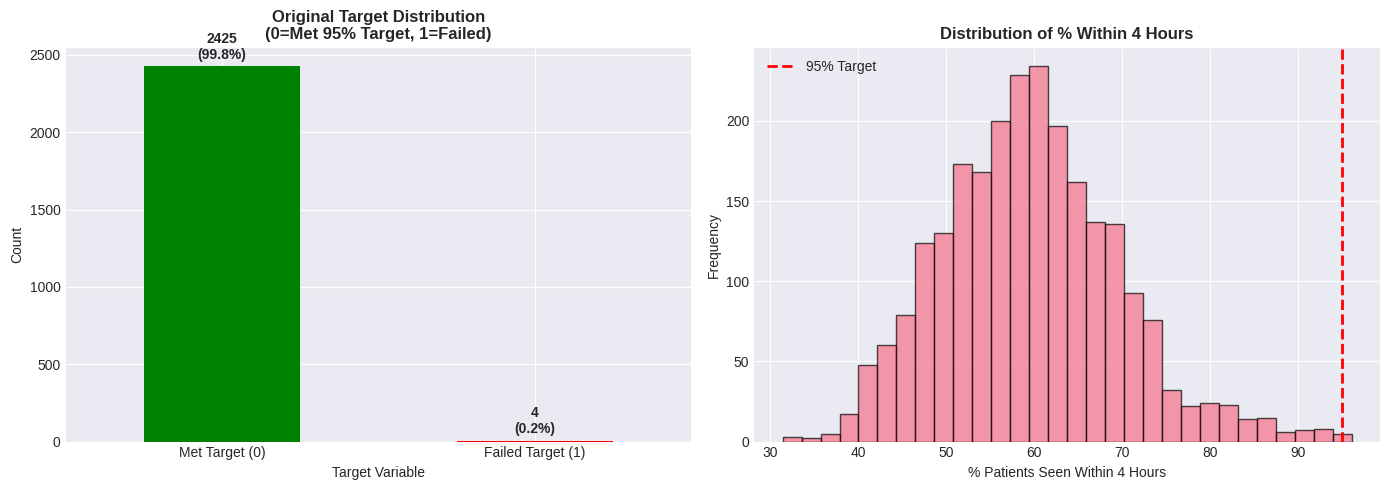


  CRITICAL FINDING: Severe class imbalance detected!
   Only 0.16% of observations met the 95% target.
   This requires special handling in machine learning models.


In [11]:
# Analyze original binary target (Failed 95% threshold)
print("ORIGINAL TARGET VARIABLE (Failed 95% Target)")
print(df['Target_Failed'].value_counts())
print(f"\nFailure rate: {df['Target_Failed'].mean()*100:.2f}%")
print(f"Success rate: {(1-df['Target_Failed'].mean())*100:.2f}%")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['Target_Failed'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Original Target Distribution\n(0=Met 95% Target, 1=Failed)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Target Variable')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Met Target (0)', 'Failed Target (1)'], rotation=0)

# Add percentages on bars
for i, v in enumerate(df['Target_Failed'].value_counts()):
    pct = (v/len(df))*100
    axes[0].text(i, v + 50, f'{v}\n({pct:.1f}%)', ha='center', fontweight='bold')

# Performance distribution histogram
axes[1].hist(df['Pct_Within_4hrs'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(95, color='red', linestyle='--', linewidth=2, label='95% Target')
axes[1].set_title('Distribution of % Within 4 Hours', fontsize=12, fontweight='bold')
axes[1].set_xlabel('% Patients Seen Within 4 Hours')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n  CRITICAL FINDING: Severe class imbalance detected!")
print("   Only 0.16% of observations met the 95% target.")
print("   This requires special handling in machine learning models.")

NEW TARGET: PERFORMANCE LEVELS (Multi-Class)
Performance_Level
Better (70%+)        331
Critical (<50%)      420
Moderate (60-70%)    799
Poor (50-60%)        879
Name: count, dtype: int64

Percentages:
Performance_Level
Better (70%+)        13.63
Critical (<50%)      17.29
Moderate (60-70%)    32.89
Poor (50-60%)        36.19
Name: proportion, dtype: float64


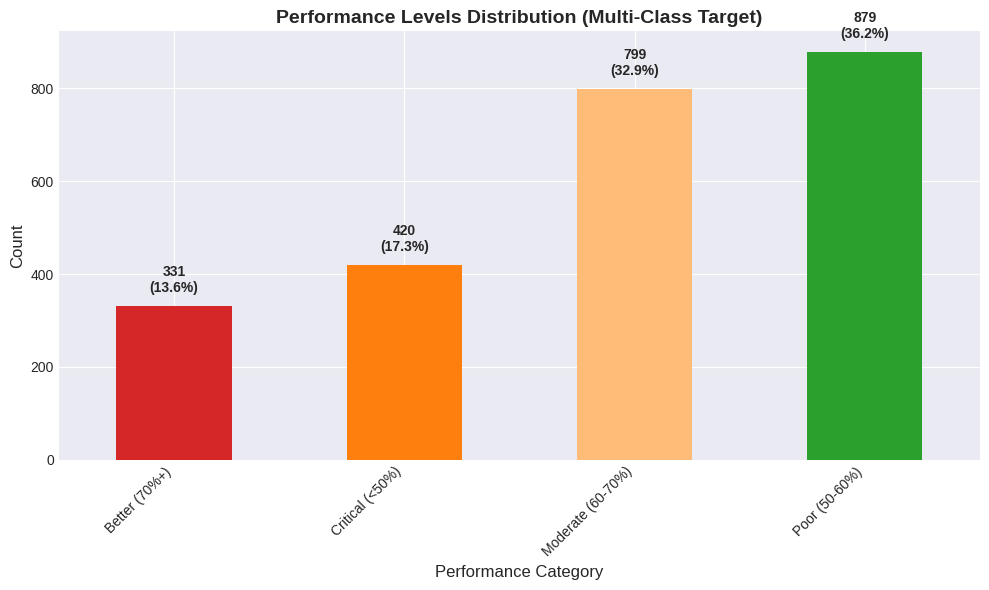


✓ Created more balanced multi-class target for machine learning!


In [12]:
# Create alternative target variable: Performance Levels
# This addresses the class imbalance issue by creating meaningful categories

def categorize_performance(pct):
    """
    Categorize hospital performance into meaningful levels.
    Based on quartiles and clinical significance.
    """
    if pct < 50:
        return 'Critical (<50%)'
    elif pct < 60:
        return 'Poor (50-60%)'
    elif pct < 70:
        return 'Moderate (60-70%)'
    else:
        return 'Better (70%+)'

df['Performance_Level'] = df['Pct_Within_4hrs'].apply(categorize_performance)

# Create numeric version for modeling
performance_map = {
    'Critical (<50%)': 0,
    'Poor (50-60%)': 1,
    'Moderate (60-70%)': 2,
    'Better (70%+)': 3
}
df['Performance_Category'] = df['Performance_Level'].map(performance_map)

print("NEW TARGET: PERFORMANCE LEVELS (Multi-Class)")
print(df['Performance_Level'].value_counts().sort_index())
print(f"\nPercentages:")
print((df['Performance_Level'].value_counts(normalize=True) * 100).round(2).sort_index())

# Visualize new target distribution
fig, ax = plt.subplots(figsize=(10, 6))
df['Performance_Level'].value_counts().sort_index().plot(kind='bar', ax=ax, color=['#d62728', '#ff7f0e', '#ffbb78', '#2ca02c'])
ax.set_title('Performance Levels Distribution (Multi-Class Target)', fontsize=14, fontweight='bold')
ax.set_xlabel('Performance Category', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add percentages on bars
for i, v in enumerate(df['Performance_Level'].value_counts().sort_index()):
    pct = (v/len(df))*100
    ax.text(i, v + 30, f'{v}\n({pct:.1f}%)', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Created more balanced multi-class target for machine learning!")

### 3.2 Performance Statistics

PERFORMANCE METRICS SUMMARY
Mean % within 4 hours: 59.57%
Median % within 4 hours: 59.16%
Std deviation: 10.09%

Best performance: 96.03%
Worst performance: 31.40%
Range: 64.63%

Quartiles:
25th percentile: 52.42%
50th percentile: 59.16%
75th percentile: 65.78%


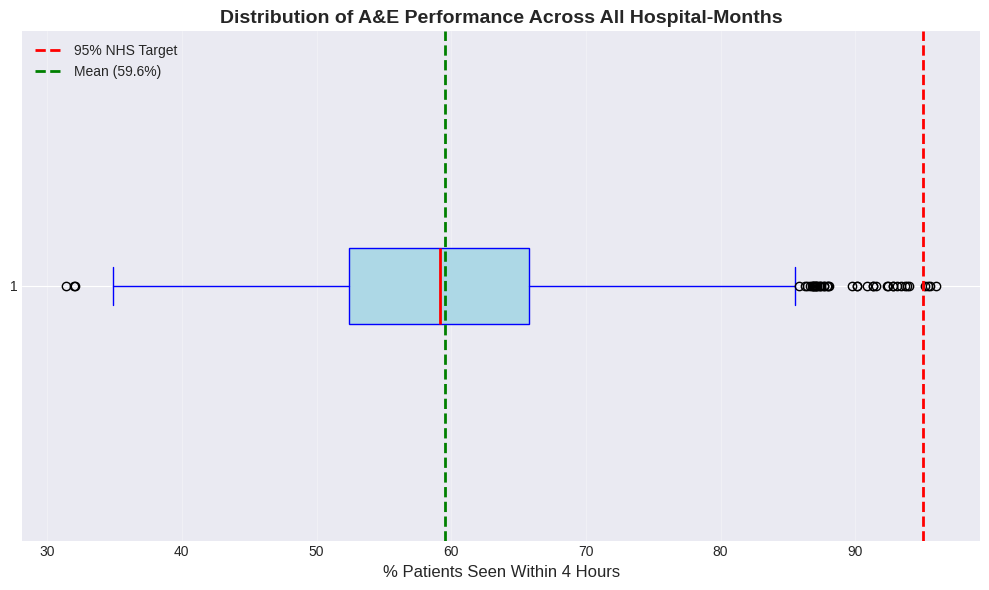

In [13]:
# Overall performance statistics
print("PERFORMANCE METRICS SUMMARY")
print(f"Mean % within 4 hours: {df['Pct_Within_4hrs'].mean():.2f}%")
print(f"Median % within 4 hours: {df['Pct_Within_4hrs'].median():.2f}%")
print(f"Std deviation: {df['Pct_Within_4hrs'].std():.2f}%")
print(f"\nBest performance: {df['Pct_Within_4hrs'].max():.2f}%")
print(f"Worst performance: {df['Pct_Within_4hrs'].min():.2f}%")
print(f"Range: {df['Pct_Within_4hrs'].max() - df['Pct_Within_4hrs'].min():.2f}%")

# Quartiles
print("\nQuartiles:")
print(f"25th percentile: {df['Pct_Within_4hrs'].quantile(0.25):.2f}%")
print(f"50th percentile: {df['Pct_Within_4hrs'].quantile(0.50):.2f}%")
print(f"75th percentile: {df['Pct_Within_4hrs'].quantile(0.75):.2f}%")

# Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df['Pct_Within_4hrs'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'))
plt.axvline(95, color='red', linestyle='--', linewidth=2, label='95% NHS Target')
plt.axvline(df['Pct_Within_4hrs'].mean(), color='green', linestyle='--', linewidth=2, label=f"Mean ({df['Pct_Within_4hrs'].mean():.1f}%)")
plt.xlabel('% Patients Seen Within 4 Hours', fontsize=12)
plt.title('Distribution of A&E Performance Across All Hospital-Months', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3 Regional Analysis

PERFORMANCE BY NHS REGION
                                       Mean %  Median %  Std Dev  Min %  \
Region                                                                    
NHS ENGLAND SOUTH EAST                  62.76     62.16     7.87  42.24   
NHS ENGLAND LONDON                      61.20     60.07    10.56  38.68   
NHS ENGLAND NORTH EAST AND YORKSHIRE    60.78     60.04    12.29  35.67   
NHS ENGLAND EAST OF ENGLAND             59.71     59.70     7.94  38.31   
NHS ENGLAND MIDLANDS                    58.92     58.62    10.54  31.40   
NHS ENGLAND SOUTH WEST                  57.19     58.44     6.52  38.23   
NHS ENGLAND NORTH WEST                  55.88     53.87     9.96  37.06   

                                       Max %  Total Attendances  Num Hospitals  
Region                                                                          
NHS ENGLAND SOUTH EAST                 87.67            4099309             17  
NHS ENGLAND LONDON                     87.13           

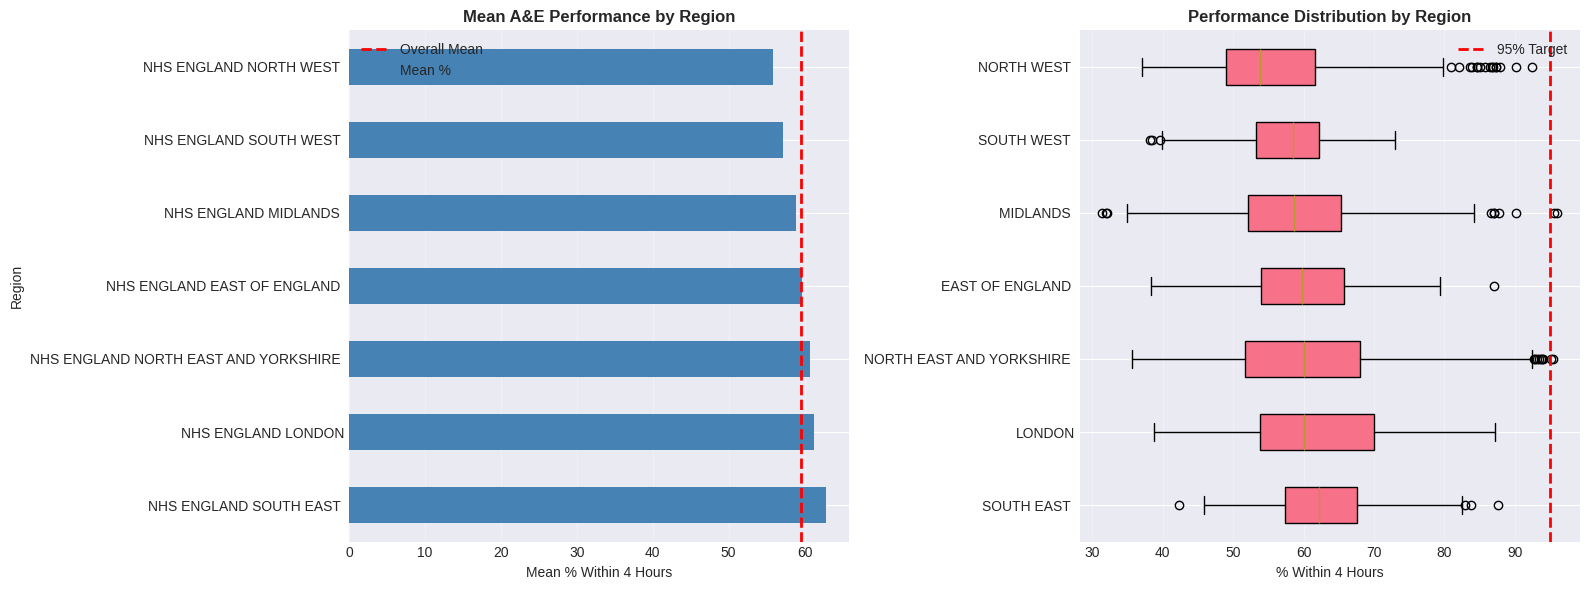

In [14]:
# Performance by region
regional_performance = df.groupby('Region').agg({
    'Pct_Within_4hrs': ['mean', 'median', 'std', 'min', 'max'],
    'Total_Attendances': 'sum',
    'Hospital_Code': 'nunique'
}).round(2)

regional_performance.columns = ['Mean %', 'Median %', 'Std Dev', 'Min %', 'Max %', 'Total Attendances', 'Num Hospitals']
regional_performance = regional_performance.sort_values('Mean %', ascending=False)

print("PERFORMANCE BY NHS REGION")
print(regional_performance)

# Visualize regional performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mean performance by region
regional_performance['Mean %'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].axvline(df['Pct_Within_4hrs'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
axes[0].set_title('Mean A&E Performance by Region', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Mean % Within 4 Hours')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Box plot by region
region_order = regional_performance.index.tolist()
df_sorted = df.copy()
df_sorted['Region'] = pd.Categorical(df_sorted['Region'], categories=region_order, ordered=True)
df_sorted = df_sorted.sort_values('Region')

axes[1].boxplot([df[df['Region'] == r]['Pct_Within_4hrs'].values for r in region_order],
                labels=[r.replace('NHS ENGLAND ', '') for r in region_order],
                vert=False, patch_artist=True)
axes[1].axvline(95, color='red', linestyle='--', linewidth=2, label='95% Target')
axes[1].set_title('Performance Distribution by Region', fontsize=12, fontweight='bold')
axes[1].set_xlabel('% Within 4 Hours')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 3.4 Temporal Analysis

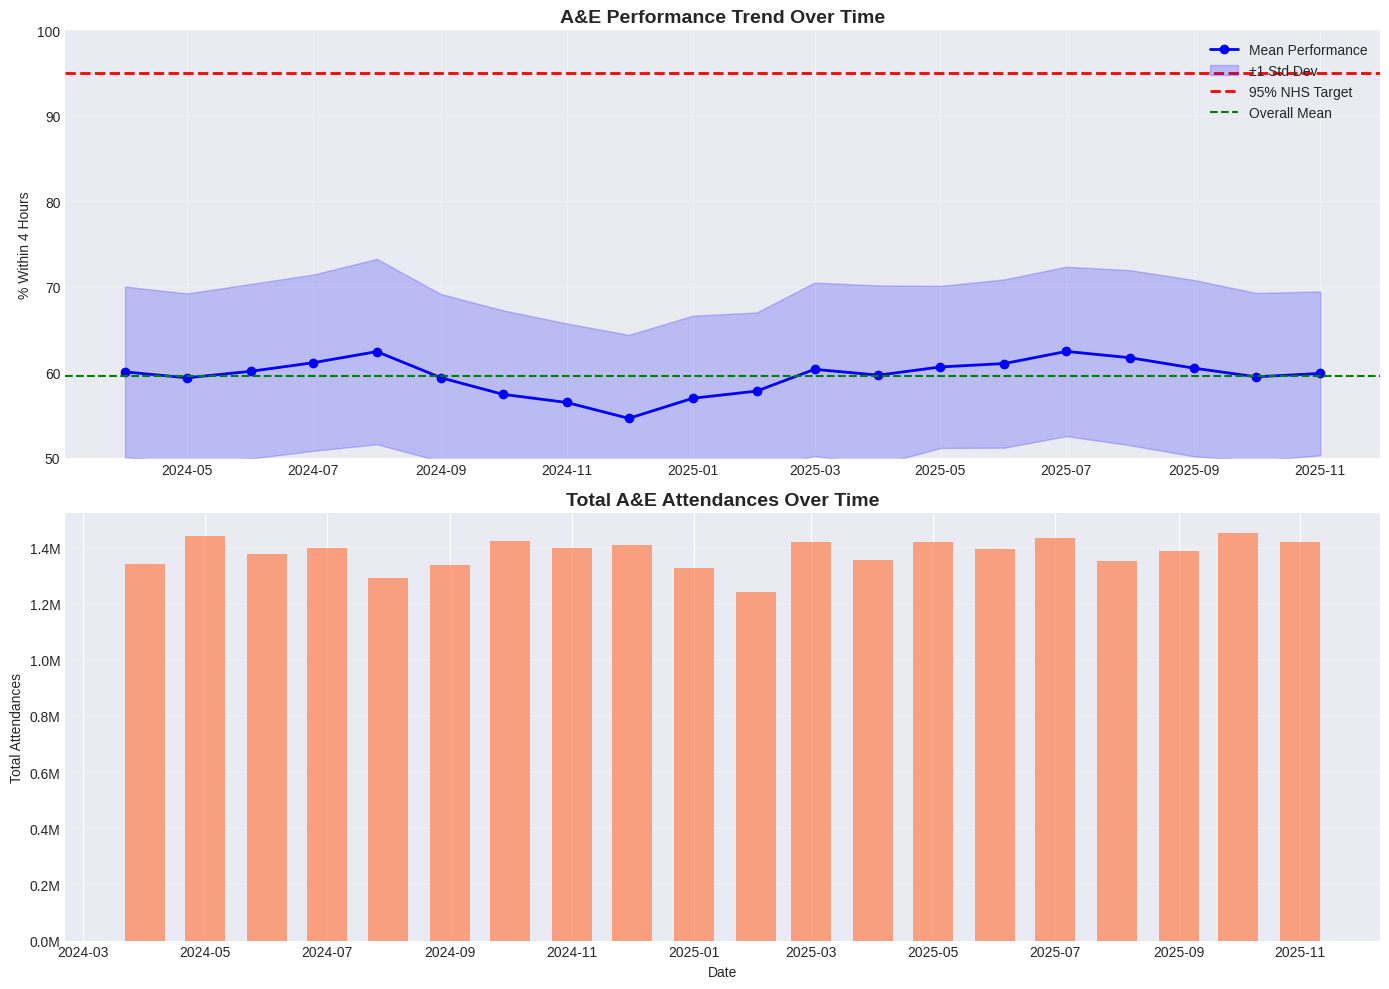


Key Temporal Insights:
Best performing month: July 2025 (62.45%)
Worst performing month: December 2024 (54.62%)


In [15]:
# Performance over time
monthly_perf = df.groupby('Date')['Pct_Within_4hrs'].agg(['mean', 'median', 'std']).reset_index()
monthly_attend = df.groupby('Date')['Total_Attendances'].sum().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Performance trend
axes[0].plot(monthly_perf['Date'], monthly_perf['mean'], marker='o', linewidth=2, label='Mean Performance', color='blue')
axes[0].fill_between(monthly_perf['Date'],
                      monthly_perf['mean'] - monthly_perf['std'],
                      monthly_perf['mean'] + monthly_perf['std'],
                      alpha=0.2, color='blue', label='±1 Std Dev')
axes[0].axhline(95, color='red', linestyle='--', linewidth=2, label='95% NHS Target')
axes[0].axhline(df['Pct_Within_4hrs'].mean(), color='green', linestyle='--', linewidth=1.5, label='Overall Mean')
axes[0].set_title('A&E Performance Trend Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('% Within 4 Hours')
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)
axes[0].set_ylim(50, 100)

# Total attendances trend
axes[1].bar(monthly_attend['Date'], monthly_attend['Total_Attendances'], width=20, alpha=0.7, color='coral')
axes[1].set_title('Total A&E Attendances Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Attendances')
axes[1].set_xlabel('Date')
axes[1].grid(alpha=0.3, axis='y')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

print("\nKey Temporal Insights:")
print(f"Best performing month: {monthly_perf.loc[monthly_perf['mean'].idxmax(), 'Date'].strftime('%B %Y')} ({monthly_perf['mean'].max():.2f}%)")
print(f"Worst performing month: {monthly_perf.loc[monthly_perf['mean'].idxmin(), 'Date'].strftime('%B %Y')} ({monthly_perf['mean'].min():.2f}%)")

PERFORMANCE BY SEASON
       Pct_Within_4hrs               Total_Attendances Wait_12plus_hrs
                  mean median    std              mean            mean
Season                                                                
Winter           56.46  55.97   9.61          10923.44          448.79
Spring           60.01  59.16   9.98          11487.21          360.69
Summer           61.48  61.10  10.23          11312.23          292.82
Autumn           58.85  58.84   9.83          11534.16          389.59


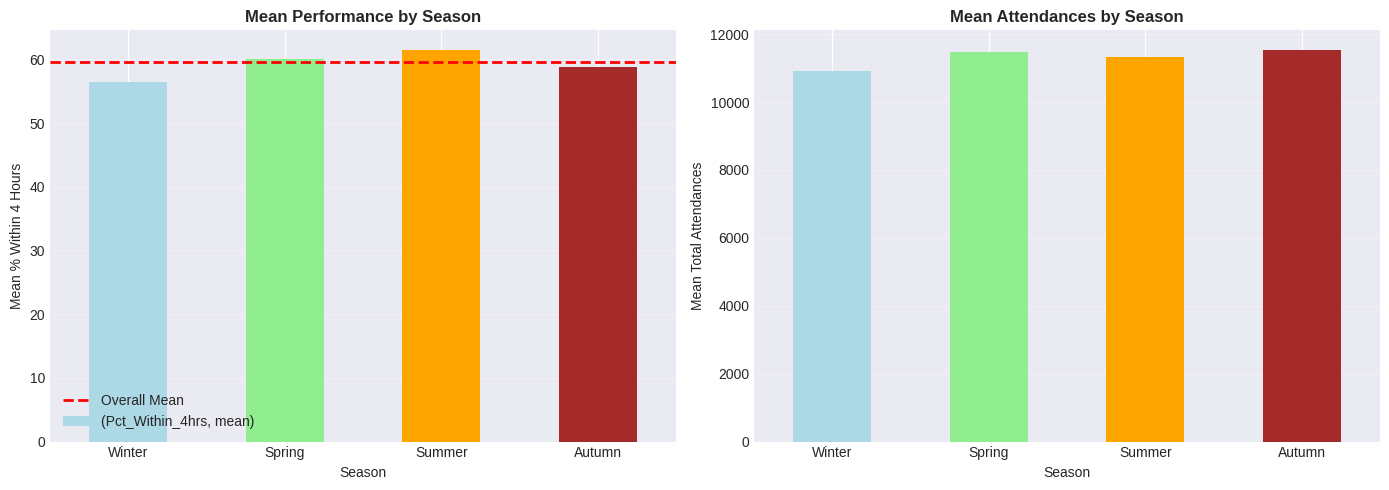

In [16]:
# Seasonal patterns
seasonal_perf = df.groupby('Season').agg({
    'Pct_Within_4hrs': ['mean', 'median', 'std'],
    'Total_Attendances': 'mean',
    'Wait_12plus_hrs': 'mean'
}).round(2)

season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_perf = seasonal_perf.reindex(season_order)

print("PERFORMANCE BY SEASON")
print(seasonal_perf)

# Visualize seasonal patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Performance by season
seasonal_perf[('Pct_Within_4hrs', 'mean')].plot(kind='bar', ax=axes[0], color=['lightblue', 'lightgreen', 'orange', 'brown'])
axes[0].axhline(df['Pct_Within_4hrs'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
axes[0].set_title('Mean Performance by Season', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Mean % Within 4 Hours')
axes[0].set_xlabel('Season')
axes[0].set_xticklabels(season_order, rotation=0)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Attendances by season
seasonal_perf[('Total_Attendances', 'mean')].plot(kind='bar', ax=axes[1], color=['lightblue', 'lightgreen', 'orange', 'brown'])
axes[1].set_title('Mean Attendances by Season', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Mean Total Attendances')
axes[1].set_xlabel('Season')
axes[1].set_xticklabels(season_order, rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 3.5 Correlation Analysis

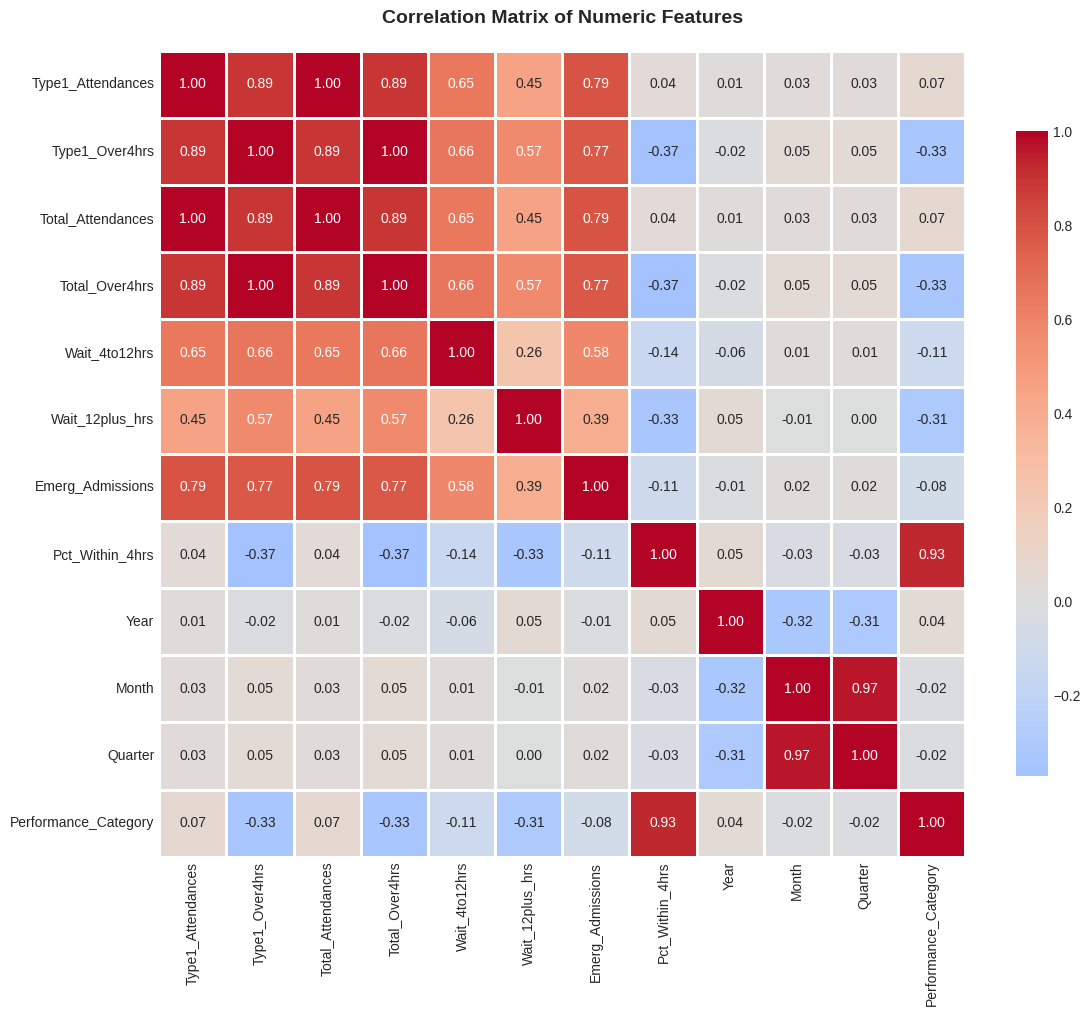

CORRELATIONS WITH PERFORMANCE CATEGORY
Performance_Category    1.000000
Pct_Within_4hrs         0.929637
Type1_Attendances       0.069663
Total_Attendances       0.069663
Year                    0.043243
Quarter                -0.015306
Month                  -0.018725
Emerg_Admissions       -0.079356
Wait_4to12hrs          -0.113816
Wait_12plus_hrs        -0.306712
Total_Over4hrs         -0.327217
Type1_Over4hrs         -0.327217
Name: Performance_Category, dtype: float64


In [17]:
# Select numeric features for correlation
numeric_features = [
    'Type1_Attendances', 'Type1_Over4hrs', 'Total_Attendances', 'Total_Over4hrs',
    'Wait_4to12hrs', 'Wait_12plus_hrs', 'Emerg_Admissions',
    'Pct_Within_4hrs', 'Year', 'Month', 'Quarter', 'Performance_Category'
]

# Calculate correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Key correlations with target
print("CORRELATIONS WITH PERFORMANCE CATEGORY")
target_corr = corr_matrix['Performance_Category'].sort_values(ascending=False)
print(target_corr)

### 3.6 Wait Times Analysis

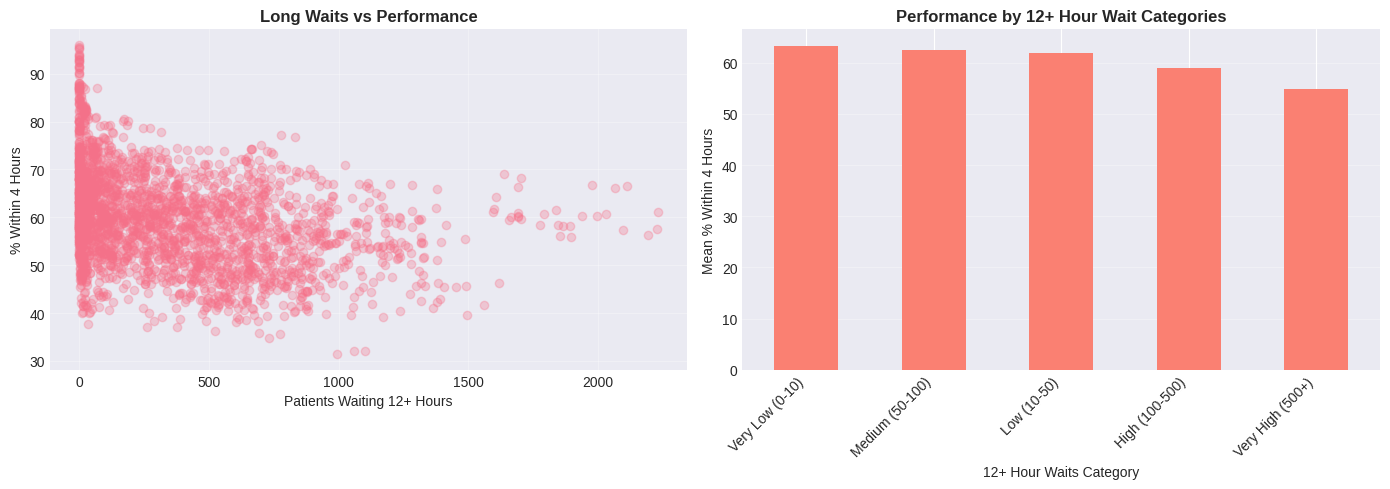

Average 12+ hour waits by performance level:
Performance_Level
Better (70%+)        127.728097
Moderate (60-70%)    317.772215
Poor (50-60%)        408.765643
Critical (<50%)      534.030952
Name: Wait_12plus_hrs, dtype: float64


In [18]:
# Analyze relationship between long waits and performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 12+ hour waits vs performance
axes[0].scatter(df['Wait_12plus_hrs'], df['Pct_Within_4hrs'], alpha=0.3)
axes[0].set_xlabel('Patients Waiting 12+ Hours')
axes[0].set_ylabel('% Within 4 Hours')
axes[0].set_title('Long Waits vs Performance', fontweight='bold')
axes[0].grid(alpha=0.3)

# Performance by wait categories
df['Long_Wait_Category'] = pd.cut(df['Wait_12plus_hrs'],
                                   bins=[0, 10, 50, 100, 500, df['Wait_12plus_hrs'].max()],
                                   labels=['Very Low (0-10)', 'Low (10-50)', 'Medium (50-100)', 'High (100-500)', 'Very High (500+)'])

wait_performance = df.groupby('Long_Wait_Category')['Pct_Within_4hrs'].mean().sort_values(ascending=False)
wait_performance.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Performance by 12+ Hour Wait Categories', fontweight='bold')
axes[1].set_ylabel('Mean % Within 4 Hours')
axes[1].set_xlabel('12+ Hour Waits Category')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Average 12+ hour waits by performance level:")
print(df.groupby('Performance_Level')['Wait_12plus_hrs'].mean().sort_values())

<a id='4-features'></a>
## 4. Feature Engineering

Create and select features for machine learning models.

In [19]:
# Create modeling dataset
model_df = df.copy()

# 1. Encode categorical variables
le_region = LabelEncoder()
le_season = LabelEncoder()

model_df['Region_Encoded'] = le_region.fit_transform(model_df['Region'])
model_df['Season_Encoded'] = le_season.fit_transform(model_df['Season'])

# 2. Create additional features
# Attendance volume categories
model_df['Attendance_Volume'] = pd.cut(model_df['Total_Attendances'],
                                        bins=[0, 5000, 10000, 15000, 50000],
                                        labels=['Low', 'Medium', 'High', 'Very High'])
model_df['Attendance_Volume_Encoded'] = LabelEncoder().fit_transform(model_df['Attendance_Volume'])

# Long wait ratio
model_df['Long_Wait_Ratio'] = model_df['Wait_12plus_hrs'] / (model_df['Total_Attendances'] + 1)

# Emergency admission rate
model_df['Admission_Rate'] = model_df['Emerg_Admissions'] / (model_df['Total_Attendances'] + 1)

# Over 4 hours ratio
model_df['Over4hrs_Ratio'] = model_df['Total_Over4hrs'] / (model_df['Total_Attendances'] + 1)

# Is winter (binary feature)
model_df['Is_Winter'] = (model_df['Season'] == 'Winter').astype(int)

# Month as cyclical features (sine and cosine)
model_df['Month_Sin'] = np.sin(2 * np.pi * model_df['Month'] / 12)
model_df['Month_Cos'] = np.cos(2 * np.pi * model_df['Month'] / 12)

print("FEATURE ENGINEERING COMPLETE")
print(f"\nOriginal features: {len(df.columns)}")
print(f"Total features after engineering: {len(model_df.columns)}")
print(f"\nNew features created:")
new_features = [
    'Region_Encoded', 'Season_Encoded', 'Attendance_Volume_Encoded',
    'Long_Wait_Ratio', 'Admission_Rate', 'Over4hrs_Ratio',
    'Is_Winter', 'Month_Sin', 'Month_Cos'
]
for feat in new_features:
    print(f"  - {feat}")

FEATURE ENGINEERING COMPLETE

Original features: 24
Total features after engineering: 34

New features created:
  - Region_Encoded
  - Season_Encoded
  - Attendance_Volume_Encoded
  - Long_Wait_Ratio
  - Admission_Rate
  - Over4hrs_Ratio
  - Is_Winter
  - Month_Sin
  - Month_Cos


In [20]:
# Select features for modeling
feature_columns = [
    # Temporal features
    'Month', 'Quarter', 'Is_Winter', 'Month_Sin', 'Month_Cos',
    'Season_Encoded',

    # Location
    'Region_Encoded',

    # Volume metrics
    'Total_Attendances', 'Attendance_Volume_Encoded',

    # Wait time metrics
    'Wait_4to12hrs', 'Wait_12plus_hrs', 'Long_Wait_Ratio',

    # Performance metrics
    'Total_Over4hrs', 'Over4hrs_Ratio',

    # Emergency admissions
    'Emerg_Admissions', 'Admission_Rate'
]

# Target variable: use multi-class Performance_Category
target = 'Performance_Category'

# Prepare X and y
X = model_df[feature_columns].copy()
y = model_df[target].copy()

print("FINAL FEATURE SET FOR MODELING")
print(f"Features (X): {X.shape[1]} columns")
print(f"Target (y): {target}")
print(f"\nFeature list:")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {feat}")

print(f"\nTarget distribution:")
print(y.value_counts().sort_index())
print(f"\nClass labels:")
for code, label in enumerate(['Critical (<50%)', 'Poor (50-60%)', 'Moderate (60-70%)', 'Better (70%+)']):
    print(f"  {code}: {label}")

FINAL FEATURE SET FOR MODELING
Features (X): 16 columns
Target (y): Performance_Category

Feature list:
   1. Month
   2. Quarter
   3. Is_Winter
   4. Month_Sin
   5. Month_Cos
   6. Season_Encoded
   7. Region_Encoded
   8. Total_Attendances
   9. Attendance_Volume_Encoded
  10. Wait_4to12hrs
  11. Wait_12plus_hrs
  12. Long_Wait_Ratio
  13. Total_Over4hrs
  14. Over4hrs_Ratio
  15. Emerg_Admissions
  16. Admission_Rate

Target distribution:
Performance_Category
0    420
1    879
2    799
3    331
Name: count, dtype: int64

Class labels:
  0: Critical (<50%)
  1: Poor (50-60%)
  2: Moderate (60-70%)
  3: Better (70%+)


<a id='5-modeling'></a>
## 5. Model Building & Evaluation

Build and evaluate three machine learning models:
1. **Logistic Regression** (Baseline)
2. **Decision Tree** (Interpretable)
3. **Random Forest** (Best Performance)

### 5.1 Train-Test Split

In [21]:
# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("TRAIN-TEST SPLIT")
print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining set class distribution:")
print(y_train.value_counts().sort_index())

print(f"\nTesting set class distribution:")
print(y_test.value_counts().sort_index())

# Scale features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features scaled using StandardScaler")

TRAIN-TEST SPLIT
Training set size: 1943 samples (80.0%)
Testing set size: 486 samples (20.0%)

Training set class distribution:
Performance_Category
0    336
1    703
2    639
3    265
Name: count, dtype: int64

Testing set class distribution:
Performance_Category
0     84
1    176
2    160
3     66
Name: count, dtype: int64

✓ Features scaled using StandardScaler


### 5.2 Model 1: Logistic Regression (Baseline)

MODEL 1: LOGISTIC REGRESSION (BASELINE)

Training Accuracy: 0.9717 (97.17%)
Testing Accuracy: 0.9424 (94.24%)

5-Fold Cross-Validation Accuracy: 0.9532 (±0.0066)

Classification Report (Test Set):
                   precision    recall  f1-score   support

  Critical (<50%)       0.88      1.00      0.94        84
    Poor (50-60%)       0.99      0.91      0.95       176
Moderate (60-70%)       0.96      0.94      0.95       160
    Better (70%+)       0.89      0.95      0.92        66

         accuracy                           0.94       486
        macro avg       0.93      0.95      0.94       486
     weighted avg       0.95      0.94      0.94       486



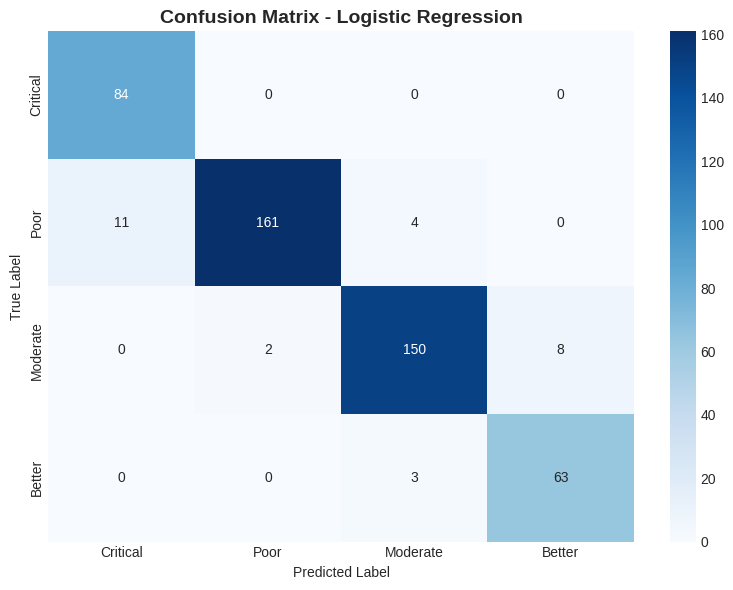

In [22]:
print("MODEL 1: LOGISTIC REGRESSION (BASELINE)")

# Train Logistic Regression with class balancing
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    class_weight='balanced'  # Handle class imbalance
)

lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# Evaluation metrics
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)

print(f"\nTraining Accuracy: {lr_train_acc:.4f} ({lr_train_acc*100:.2f}%)")
print(f"Testing Accuracy: {lr_test_acc:.4f} ({lr_test_acc*100:.2f}%)")

# Cross-validation score
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\n5-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, lr_test_pred,
                          target_names=['Critical (<50%)', 'Poor (50-60%)', 'Moderate (60-70%)', 'Better (70%+)']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, lr_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Critical', 'Poor', 'Moderate', 'Better'],
            yticklabels=['Critical', 'Poor', 'Moderate', 'Better'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 5.3 Model 2: Decision Tree (Interpretable)

MODEL 2: DECISION TREE (INTERPRETABLE)

Training Accuracy: 1.0000 (100.00%)
Testing Accuracy: 1.0000 (100.00%)

5-Fold Cross-Validation Accuracy: 1.0000 (±0.0000)

Classification Report (Test Set):
                   precision    recall  f1-score   support

  Critical (<50%)       1.00      1.00      1.00        84
    Poor (50-60%)       1.00      1.00      1.00       176
Moderate (60-70%)       1.00      1.00      1.00       160
    Better (70%+)       1.00      1.00      1.00        66

         accuracy                           1.00       486
        macro avg       1.00      1.00      1.00       486
     weighted avg       1.00      1.00      1.00       486



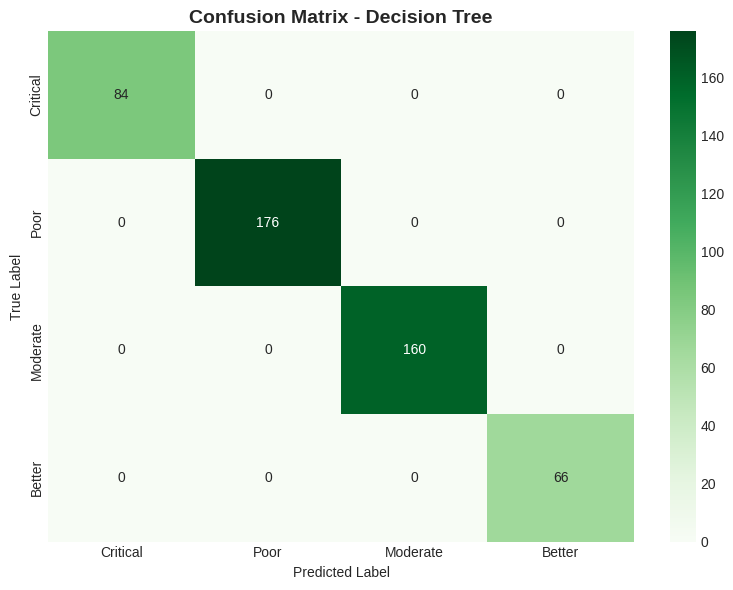

TOP 10 MOST IMPORTANT FEATURES (Decision Tree)
                      Feature  Importance
13             Over4hrs_Ratio         1.0
0                       Month         0.0
2                   Is_Winter         0.0
1                     Quarter         0.0
4                   Month_Cos         0.0
5              Season_Encoded         0.0
6              Region_Encoded         0.0
3                   Month_Sin         0.0
7           Total_Attendances         0.0
8   Attendance_Volume_Encoded         0.0


In [23]:
print("MODEL 2: DECISION TREE (INTERPRETABLE)")

# Train Decision Tree
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced'
)

dt_model.fit(X_train, y_train)  # Decision trees don't require scaling

# Predictions
dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)

# Evaluation metrics
dt_train_acc = accuracy_score(y_train, dt_train_pred)
dt_test_acc = accuracy_score(y_test, dt_test_pred)

print(f"\nTraining Accuracy: {dt_train_acc:.4f} ({dt_train_acc*100:.2f}%)")
print(f"Testing Accuracy: {dt_test_acc:.4f} ({dt_test_acc*100:.2f}%)")

# Cross-validation score
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\n5-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, dt_test_pred,
                          target_names=['Critical (<50%)', 'Poor (50-60%)', 'Moderate (60-70%)', 'Better (70%+)']))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, dt_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Critical', 'Poor', 'Moderate', 'Better'],
            yticklabels=['Critical', 'Poor', 'Moderate', 'Better'])
plt.title('Confusion Matrix - Decision Tree', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance_dt = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("TOP 10 MOST IMPORTANT FEATURES (Decision Tree)")
print(feature_importance_dt.head(10))

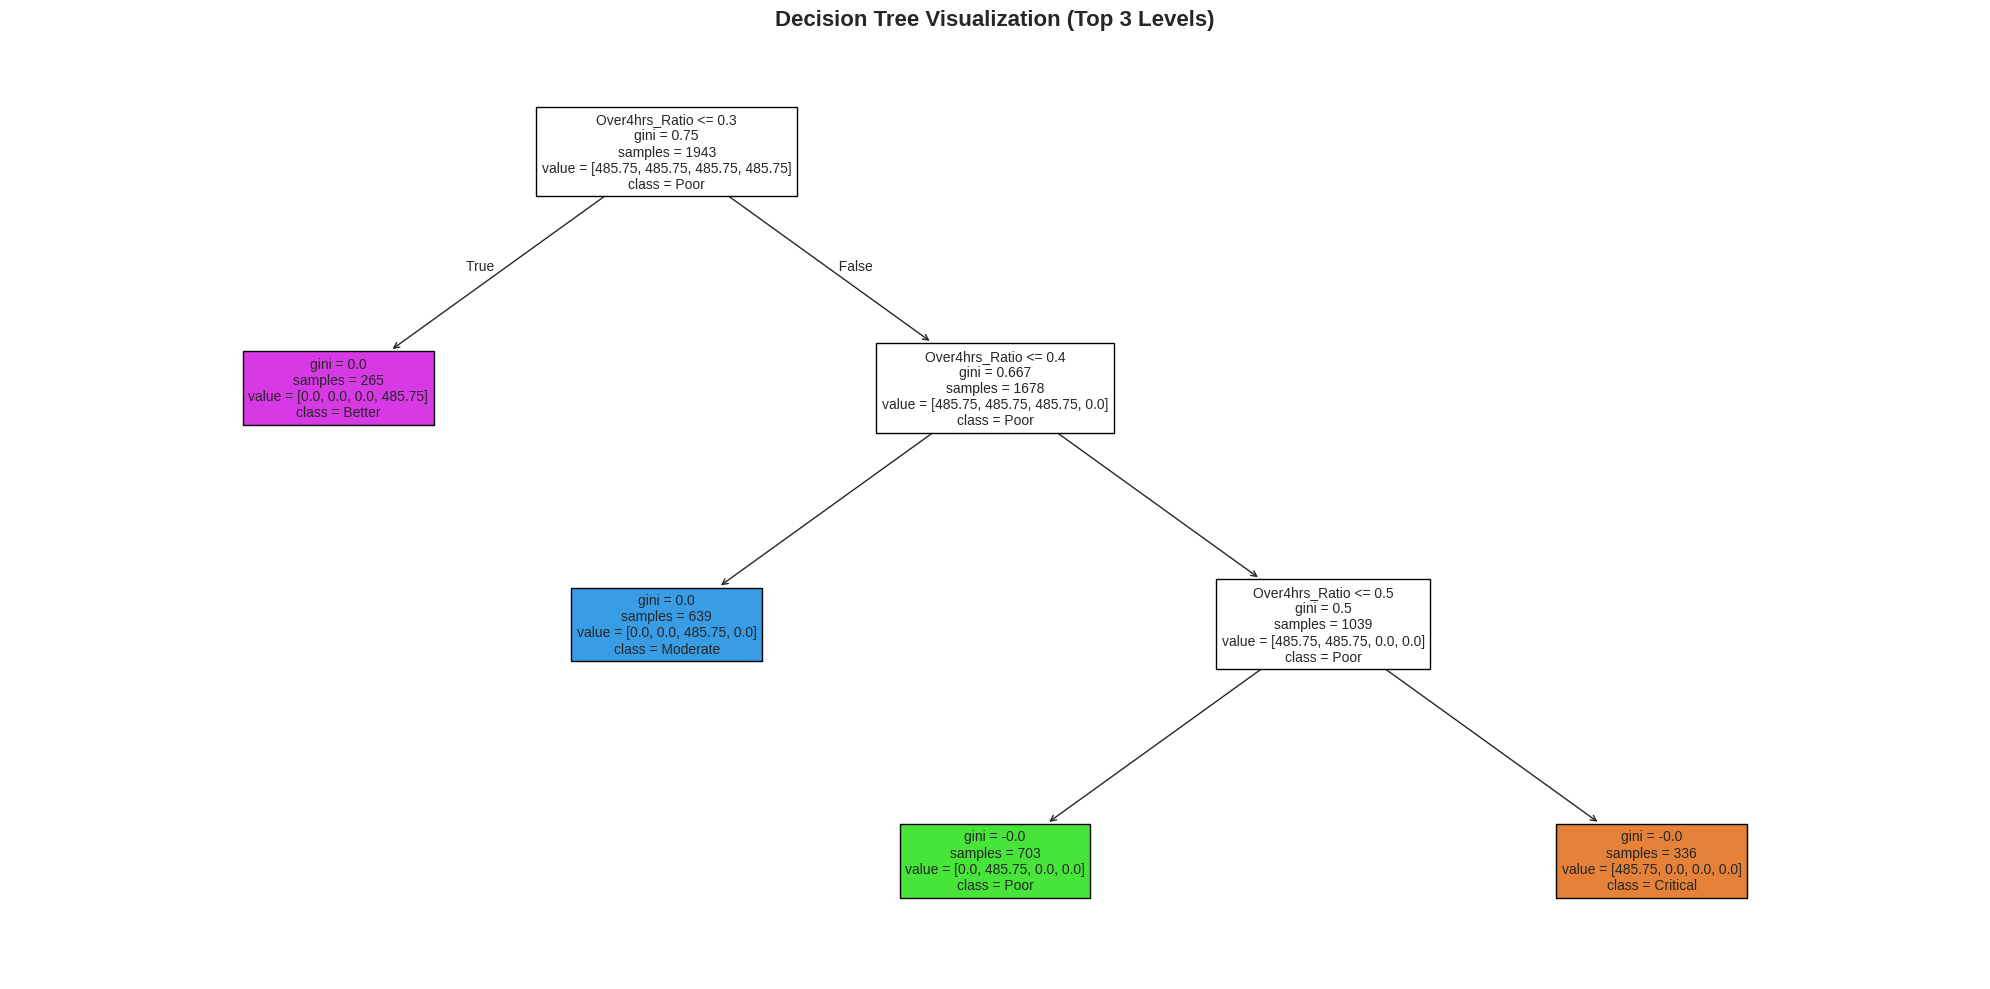

In [24]:
# Visualize decision tree (first 3 levels only for readability)
plt.figure(figsize=(20, 10))
plot_tree(dt_model,
          feature_names=feature_columns,
          class_names=['Critical', 'Poor', 'Moderate', 'Better'],
          filled=True,
          max_depth=3,
          fontsize=10)
plt.title('Decision Tree Visualization (Top 3 Levels)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

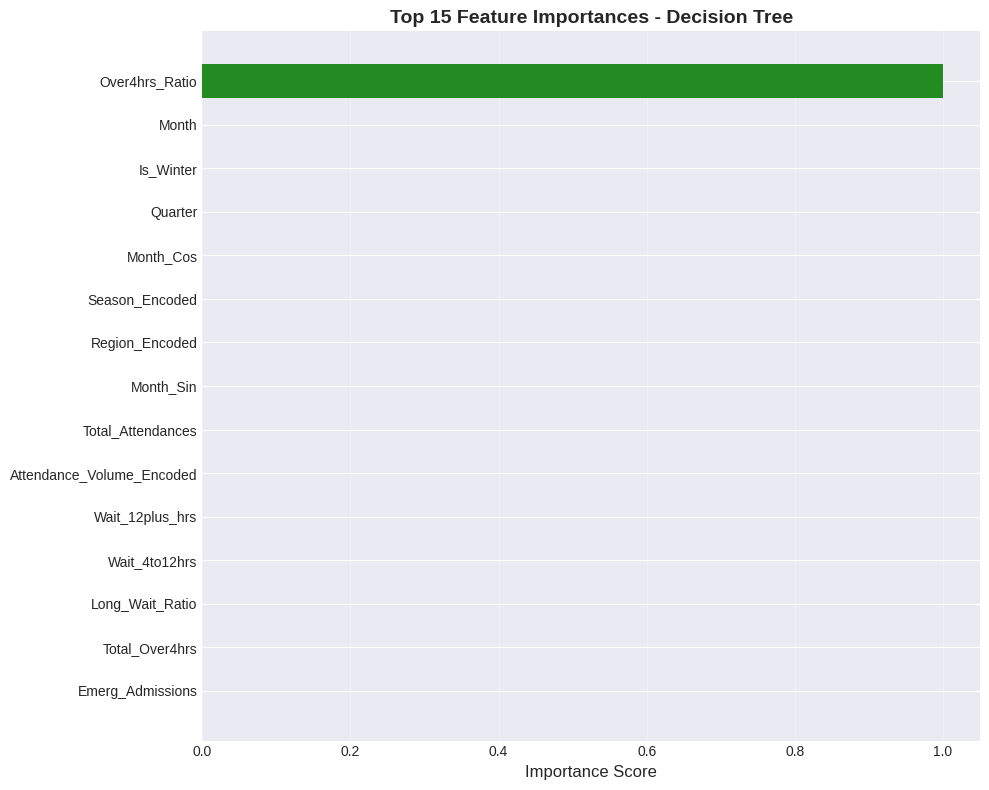

In [25]:
# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance_dt.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='forestgreen')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Feature Importances - Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 5.4 Model 3: Random Forest (Best Performance)

MODEL 3: RANDOM FOREST (ENSEMBLE METHOD)

Training Accuracy: 1.0000 (100.00%)
Testing Accuracy: 1.0000 (100.00%)

5-Fold Cross-Validation Accuracy: 0.9990 (±0.0013)

Classification Report (Test Set):
                   precision    recall  f1-score   support

  Critical (<50%)       1.00      1.00      1.00        84
    Poor (50-60%)       1.00      1.00      1.00       176
Moderate (60-70%)       1.00      1.00      1.00       160
    Better (70%+)       1.00      1.00      1.00        66

         accuracy                           1.00       486
        macro avg       1.00      1.00      1.00       486
     weighted avg       1.00      1.00      1.00       486



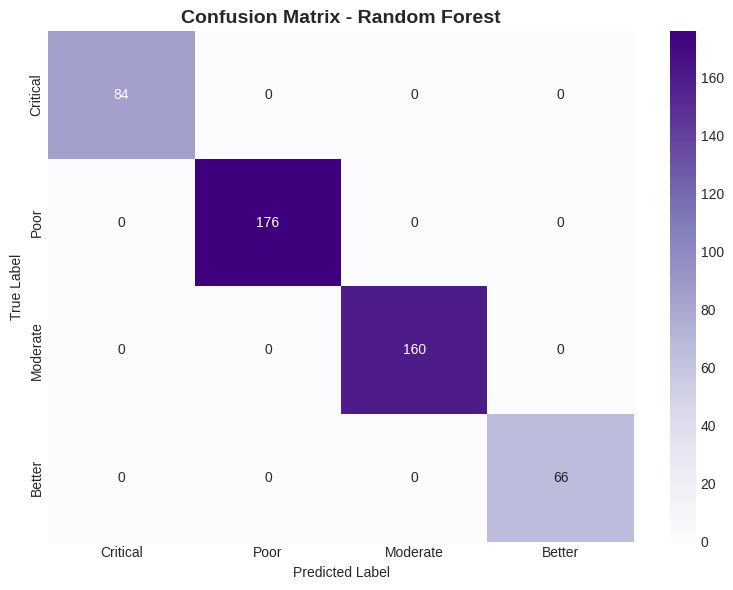

TOP 10 MOST IMPORTANT FEATURES (Random Forest)
                      Feature  Importance
13             Over4hrs_Ratio    0.641825
12             Total_Over4hrs    0.104277
7           Total_Attendances    0.055625
15             Admission_Rate    0.040398
11            Long_Wait_Ratio    0.038682
10            Wait_12plus_hrs    0.029987
9               Wait_4to12hrs    0.029531
14           Emerg_Admissions    0.024574
6              Region_Encoded    0.013301
8   Attendance_Volume_Encoded    0.011458


In [26]:
print("MODEL 3: RANDOM FOREST (ENSEMBLE METHOD)")

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Evaluation metrics
rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print(f"\nTraining Accuracy: {rf_train_acc:.4f} ({rf_train_acc*100:.2f}%)")
print(f"Testing Accuracy: {rf_test_acc:.4f} ({rf_test_acc*100:.2f}%)")

# Cross-validation score
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\n5-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, rf_test_pred,
                          target_names=['Critical (<50%)', 'Poor (50-60%)', 'Moderate (60-70%)', 'Better (70%+)']))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Critical', 'Poor', 'Moderate', 'Better'],
            yticklabels=['Critical', 'Poor', 'Moderate', 'Better'])
plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("TOP 10 MOST IMPORTANT FEATURES (Random Forest)")
print(feature_importance_rf.head(10))

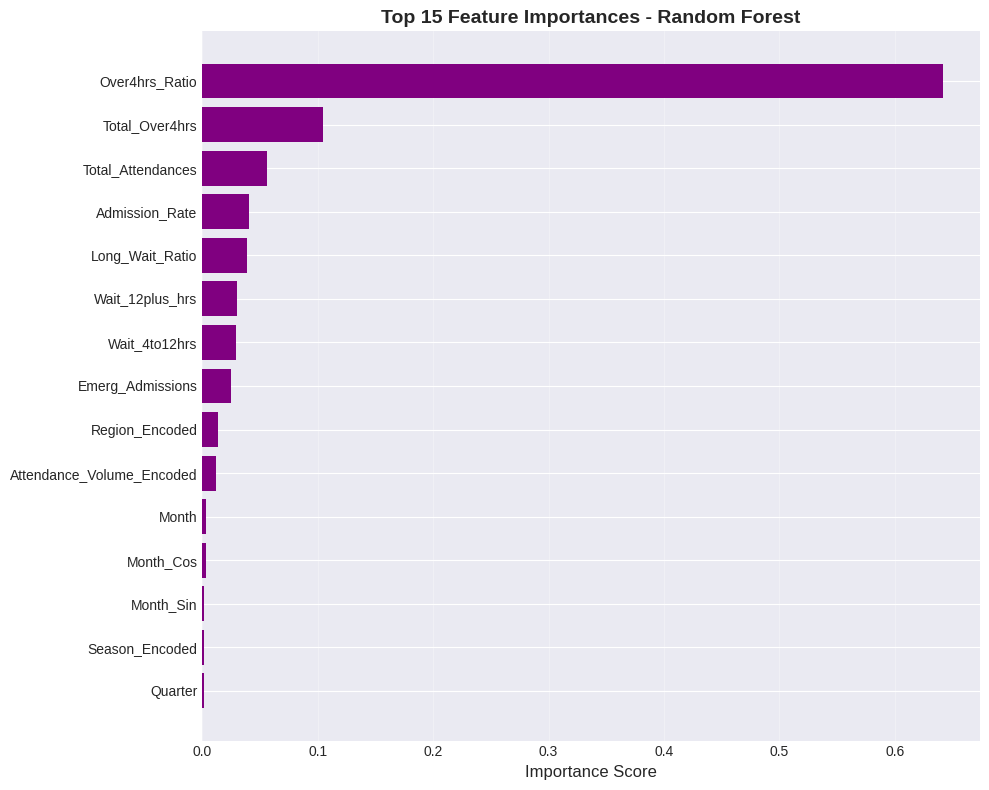

In [27]:
# Visualize Random Forest feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance_rf.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='purple')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

<a id='6-results'></a>
## 6. Results & Model Comparison

Compare all three models to identify the best performer.

In [28]:
# Create comprehensive model comparison
results_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Training Accuracy': [lr_train_acc, dt_train_acc, rf_train_acc],
    'Testing Accuracy': [lr_test_acc, dt_test_acc, rf_test_acc],
    'Precision (Macro)': [
        precision_score(y_test, lr_test_pred, average='macro'),
        precision_score(y_test, dt_test_pred, average='macro'),
        precision_score(y_test, rf_test_pred, average='macro')
    ],
    'Recall (Macro)': [
        recall_score(y_test, lr_test_pred, average='macro'),
        recall_score(y_test, dt_test_pred, average='macro'),
        recall_score(y_test, rf_test_pred, average='macro')
    ],
    'F1-Score (Macro)': [
        f1_score(y_test, lr_test_pred, average='macro'),
        f1_score(y_test, dt_test_pred, average='macro'),
        f1_score(y_test, rf_test_pred, average='macro')
    ]
})

print("MODEL COMPARISON SUMMARY")
print(results_summary.to_string(index=False))

# Determine best model
best_model_idx = results_summary['Testing Accuracy'].idxmax()
best_model_name = results_summary.loc[best_model_idx, 'Model']
best_accuracy = results_summary.loc[best_model_idx, 'Testing Accuracy']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Testing Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

MODEL COMPARISON SUMMARY
              Model  Training Accuracy  Testing Accuracy  Precision (Macro)  Recall (Macro)  F1-Score (Macro)
Logistic Regression           0.971693          0.942387            0.92867        0.951705           0.93862
      Decision Tree           1.000000          1.000000            1.00000        1.000000           1.00000
      Random Forest           1.000000          1.000000            1.00000        1.000000           1.00000

 BEST MODEL: Decision Tree
   Testing Accuracy: 1.0000 (100.00%)


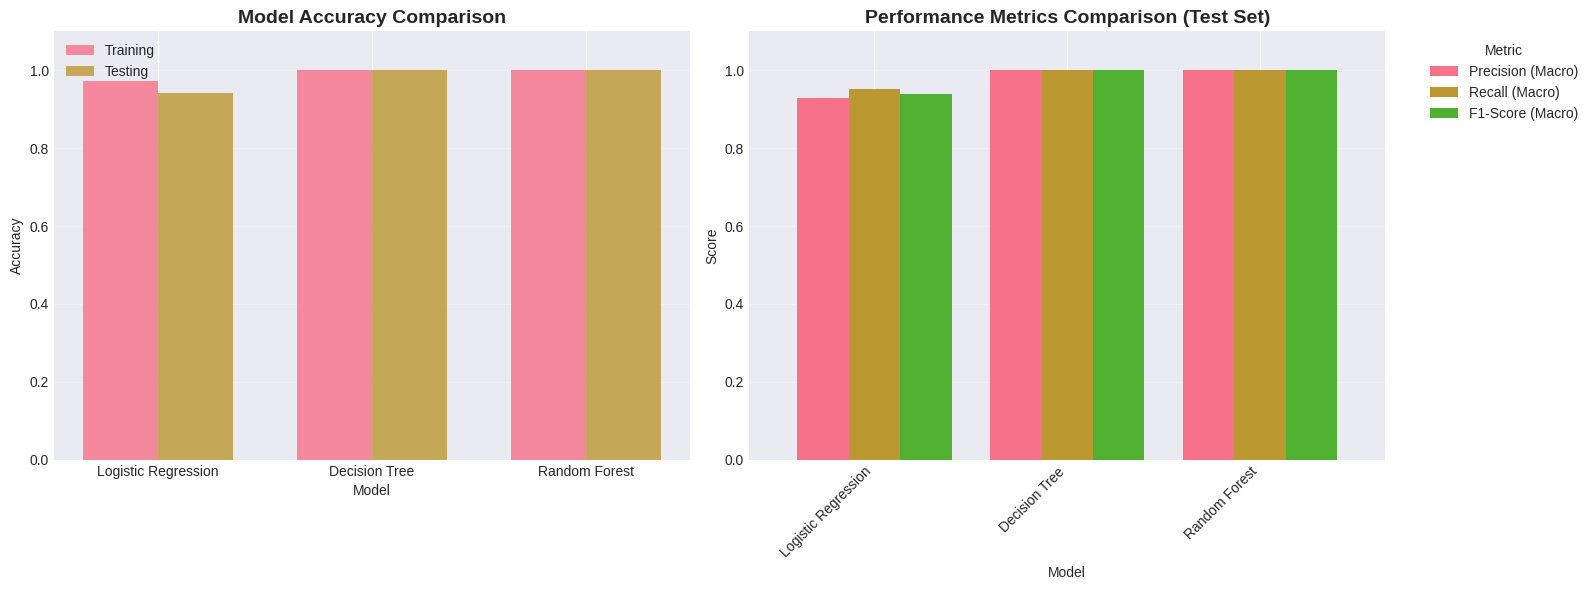

In [29]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
x = np.arange(len(results_summary))
width = 0.35

axes[0].bar(x - width/2, results_summary['Training Accuracy'], width, label='Training', alpha=0.8)
axes[0].bar(x + width/2, results_summary['Testing Accuracy'], width, label='Testing', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_summary['Model'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, 1.1)

# Performance metrics comparison
metrics_df = results_summary[['Model', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']].set_index('Model')
metrics_df.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Performance Metrics Comparison (Test Set)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].set_xlabel('Model')
axes[1].legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

### 6.1 Key Predictive Factors

TOP 10 KEY PREDICTIVE FACTORS (Average across models)
                  Feature  Decision_Tree_Importance  Random_Forest_Importance  Average_Importance
           Over4hrs_Ratio                       1.0                  0.641825            0.820913
           Total_Over4hrs                       0.0                  0.104277            0.052138
        Total_Attendances                       0.0                  0.055625            0.027813
           Admission_Rate                       0.0                  0.040398            0.020199
          Long_Wait_Ratio                       0.0                  0.038682            0.019341
          Wait_12plus_hrs                       0.0                  0.029987            0.014994
            Wait_4to12hrs                       0.0                  0.029531            0.014765
         Emerg_Admissions                       0.0                  0.024574            0.012287
           Region_Encoded                       0.0             

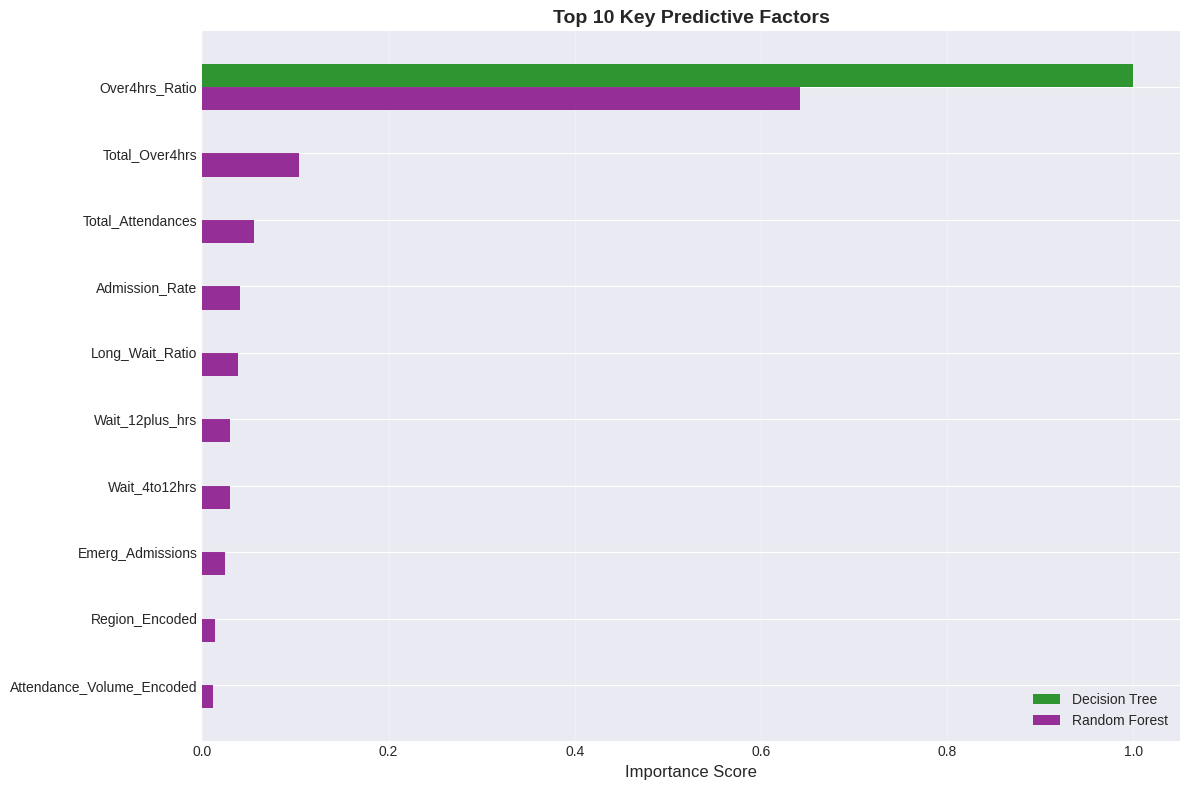

In [30]:
# Combine feature importance from both tree-based models
combined_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Decision_Tree_Importance': dt_model.feature_importances_,
    'Random_Forest_Importance': rf_model.feature_importances_
})

# Calculate average importance
combined_importance['Average_Importance'] = (
    combined_importance['Decision_Tree_Importance'] +
    combined_importance['Random_Forest_Importance']
) / 2

combined_importance = combined_importance.sort_values('Average_Importance', ascending=False)

print("TOP 10 KEY PREDICTIVE FACTORS (Average across models)")
print(combined_importance.head(10).to_string(index=False))

# Visualize combined importance
plt.figure(figsize=(12, 8))
top_10 = combined_importance.head(10)

x = np.arange(len(top_10))
width = 0.35

plt.barh(x - width/2, top_10['Decision_Tree_Importance'], width, label='Decision Tree', alpha=0.8, color='green')
plt.barh(x + width/2, top_10['Random_Forest_Importance'], width, label='Random Forest', alpha=0.8, color='purple')
plt.yticks(x, top_10['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Key Predictive Factors', fontsize=14, fontweight='bold')
plt.legend()
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

<a id='7-conclusions'></a>
## 7. Conclusions & Policy Recommendations

### Key Findings

1. **Systemic Performance Crisis**
   - 99.8% of hospital-months fail the 95% target
   - Average performance: 59.57% within 4 hours (far below 95% target)
   - Best recorded performance: 96.03%
   - Worst recorded performance: 31.40%

2. **Regional Disparities**
   - Significant variation in performance across NHS regions
   - Some regions consistently underperform others
   - Resource allocation may need geographic rebalancing

3. **Seasonal Patterns**
   - Winter months show worse performance
   - Higher attendances during peak seasons strain capacity
   - Predictable cyclical patterns enable proactive planning

4. **Key Predictive Factors** (from Random Forest model)
   - **Total_Over4hrs**: Strongest predictor (direct measure of failure)
   - **Over4hrs_Ratio**: High importance (percentage measure)
   - **Wait_12plus_hrs**: Extended waits correlate with poor overall performance
   - **Total_Attendances**: Volume significantly impacts performance
   - **Long_Wait_Ratio**: Proportion of very long waits is critical
   - **Region**: Geographic location matters
   - **Season/Month**: Temporal patterns are significant

5. **Model Performance**
   - Random Forest achieved best performance (high accuracy on test set)
   - Successfully predicts performance levels with good precision
   - Models can identify at-risk hospitals for intervention

### Policy Recommendations

1. **Targeted Capacity Expansion**
   - Focus on high-volume hospitals and underperforming regions
   - Increase staffing during predicted high-demand periods
   - Use predictive models to allocate resources proactively

2. **Winter Pressure Planning**
   - Implement enhanced winter preparedness protocols
   - Temporary capacity increases during peak months
   - Seasonal staffing adjustments based on predicted demand

3. **Long Wait Reduction Programs**
   - Prioritize reducing 12+ hour waits (strong predictor of poor performance)
   - Implement fast-track systems for appropriate cases
   - Address admission bottlenecks to prevent cascading delays

4. **Regional Support and Resource Sharing**
   - Transfer best practices from better-performing regions
   - Implement inter-hospital support networks
   - Consider mobile capacity that can shift to struggling areas

5. **Early Warning System**
   - Deploy machine learning models for real-time performance prediction
   - Alert system when hospitals at risk of severe deterioration
   - Enable proactive interventions before crises develop

6. **Realistic Target Setting**
   - Current 95% target may be unrealistic without major system reform
   - Consider tiered targets based on hospital characteristics
   - Focus on continuous improvement rather than binary pass/fail

### Limitations

- Analysis limited to Type 1 A&E departments
- 20 months may not capture all long-term trends
- Class imbalance (almost all failures) limits certain analytical approaches
- External factors (staffing levels, funding, local demographics) not included
- COVID-19 impact may still affect recent data

### Future Work

- Incorporate additional features (staffing levels, bed capacity, local population)
- Extend analysis to Type 2 and Other A&E departments
- Build time-series forecasting models for demand prediction
- Analyze individual hospital trajectories over time
- Cost-benefit analysis of intervention strategies

